# Exploratory Data Analysis

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot

## Setup

In [2]:
sns.set()
pd.set_option('display.max_columns', None) # display all columns in a broad DataFrame

timeStart_begin = datetime.strptime("2022-04-01T00:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%fZ")
timeStart_close = datetime.strptime("2022-04-05T00:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%fZ")

In [3]:
events = pd.read_csv('events_raw.csv', delimiter=';')
sessions = pd.read_csv('sessions_raw.csv', delimiter=';')
print("Sessions Count: {}".format(len(sessions)))
print("Events Count: {}".format(len(events)))

Sessions Count: 6246
Events Count: 244889


## Preparation

### Merge and Alter the Sessions

In [4]:
events["eventType"] = events["eventType"].astype("category")

sessions.reset_index()
eventsTypes = []
eventsTimes = []
pageUrl = []
eventsCount = []

for index, session in sessions.iterrows():
    session_events = events[events["sid"] == session["id"]]
    eventsTypes.append([i for i in session_events["eventType"].tolist() if not pd.isnull(i)])
    eventsCount.append(len(session_events))
    
    max_time = session_events["time"].max()
    min_time = 0
    partitioned_times = []
    for session_event_time in session_events["time"].tolist():
        if not pd.isnull(session_event_time):
            if session_event_time <= min_time:
                partitioned_times.append(1.0)
            elif max_time == session_event_time:
                partitioned_times.append(10.0)
            else:
                # sparse event time occurrences in a session into 10 time segments during session's duration
                partitioned_times.append(np.ceil(session_event_time / max_time * 10))
        
    eventsTimes.append(partitioned_times)
    pageUrl.append([i.replace('\'', '').strip() for i in session_events["pageUrl"] if not pd.isnull(i)])
    
sessions["eventsTypes"] = eventsTypes
sessions["eventsTimes"] = eventsTimes
sessions["pageBaseUrl"] = pageUrl
sessions["eventsCount"] = eventsCount
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6246 entries, 0 to 6245
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 6246 non-null   object 
 1   uid                4740 non-null   float64
 2   timeStart          6246 non-null   object 
 3   timeClose          6246 non-null   object 
 4   duration           6246 non-null   int64  
 5   pageReferer        3589 non-null   object 
 6   browserCode        6246 non-null   object 
 7   platformCode       6246 non-null   object 
 8   countryCode        6233 non-null   object 
 9   countryCity        5729 non-null   object 
 10  deviceType         6246 non-null   object 
 11  deviceOrientation  0 non-null      float64
 12  deviceWidth        6246 non-null   int64  
 13  deviceHeight       6246 non-null   int64  
 14  pageFirst          6246 non-null   object 
 15  pageLast           6246 non-null   object 
 16  pageUrl            6246 

### Convert Session Attributes to Correct Types

In [7]:
sessions["timeStart"] = sessions["timeStart"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
sessions["timeClose"] = sessions["timeClose"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
timeStart_seconds = (sessions["timeStart"] - timeStart_begin).apply(lambda x: x.total_seconds())
timeClose_seconds = (sessions["timeClose"] - timeStart_begin).apply(lambda x: x.total_seconds())
sessions["pageReferer"] = sessions["pageReferer"].astype("category")
sessions["browserCode"] = sessions["browserCode"].astype("category")
sessions["platformCode"] = sessions["platformCode"].astype("category")
sessions["countryCode"] = sessions["countryCode"].astype("category")
sessions["countryCity"] = sessions["countryCity"].astype("category")
sessions["deviceType"] = sessions["deviceType"].astype("category")
sessions["pageFirst"] = sessions["pageFirst"].astype("category")
sessions["pageLast"] = sessions["pageLast"].astype("category")

# Plots

## Event Type Distribution

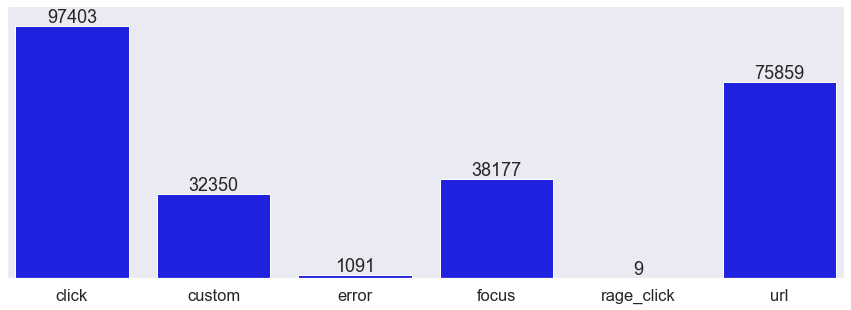

In [8]:
sns.set(rc = {'figure.figsize':(15,5)}, style="darkgrid", font_scale=1.5)
eventType_ax = sns.countplot(x=events["eventType"], color="blue")
eventType_ax.set(xlabel=None, ylabel=None, yticks=[], ylim=(0, 105000))
eventType_ax.margins(x=0.01)
eventType_ax.bar_label(eventType_ax.containers[0])
pyplot.show()

## Event Duration Distribution

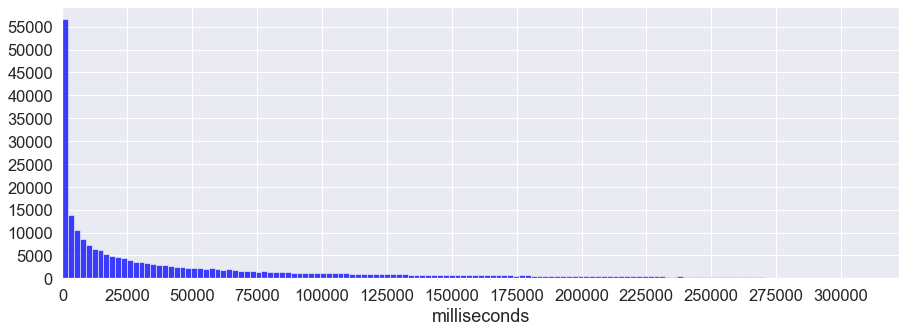

In [9]:
sns.set(rc = {'figure.figsize':(15,5)}, style="darkgrid", font_scale=1.5)
eventType_ax = sns.histplot(x=events["time"], color="blue")
eventType_ax.set(xlabel="milliseconds", ylabel=None, yticks=np.arange(0,57000,5000), xticks=np.arange(0,340000,25000))
eventType_ax.margins(x=0)
pyplot.show()

## Top Five Pages of Events

In [11]:
events["pageUrl"].value_counts()[:5]

www.smartlook.com/                                                                                                      3112
app.smartlook.com/sign/in                                                                                               1711
about:blank                                                                                                             1663
www.smartlook.com/pricing/                                                                                              1206
www.smartlook.com/blog/mobile-app-onboarding/?preview_id=956&preview_nonce=6e2ff15a55&preview=true&_thumbnail_id=957     773
Name: pageUrl, dtype: int64

## Time Start and Close Distribution

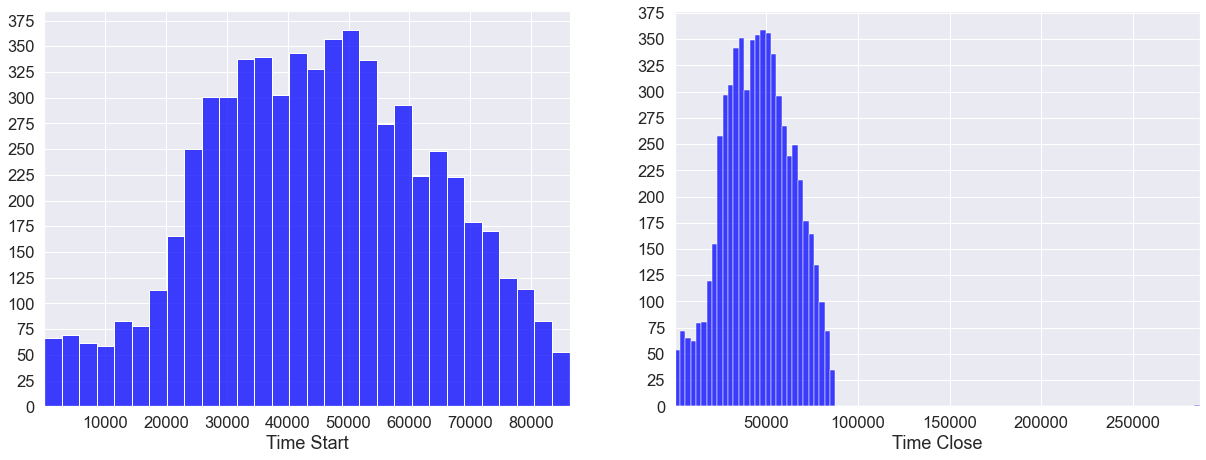

In [12]:
timeStart_seconds = (sessions["timeStart"] - timeStart_begin).apply(lambda x: x.total_seconds())
timeClose_seconds = (sessions["timeClose"] - timeStart_begin).apply(lambda x: x.total_seconds())

sns.set(rc={"figure.figsize": (32, 16)}, style="darkgrid", font_scale=1.5)
pyplot.subplot(2,3,1)
time_ax = sns.histplot(timeStart_seconds, color="blue")
time_ax.set(xlabel="Time Start", ylabel=None, yticks=np.arange(0, 400, 25))
time_ax.margins(x=0)
pyplot.subplot(2,3,2)
time_ax = sns.histplot(timeClose_seconds, color="blue")
time_ax.set(xlabel="Time Close", ylabel=None, yticks=np.arange(0, 400, 25))
time_ax.margins(x=0)
pyplot.show()

## Box Plots for Duration and Event Count

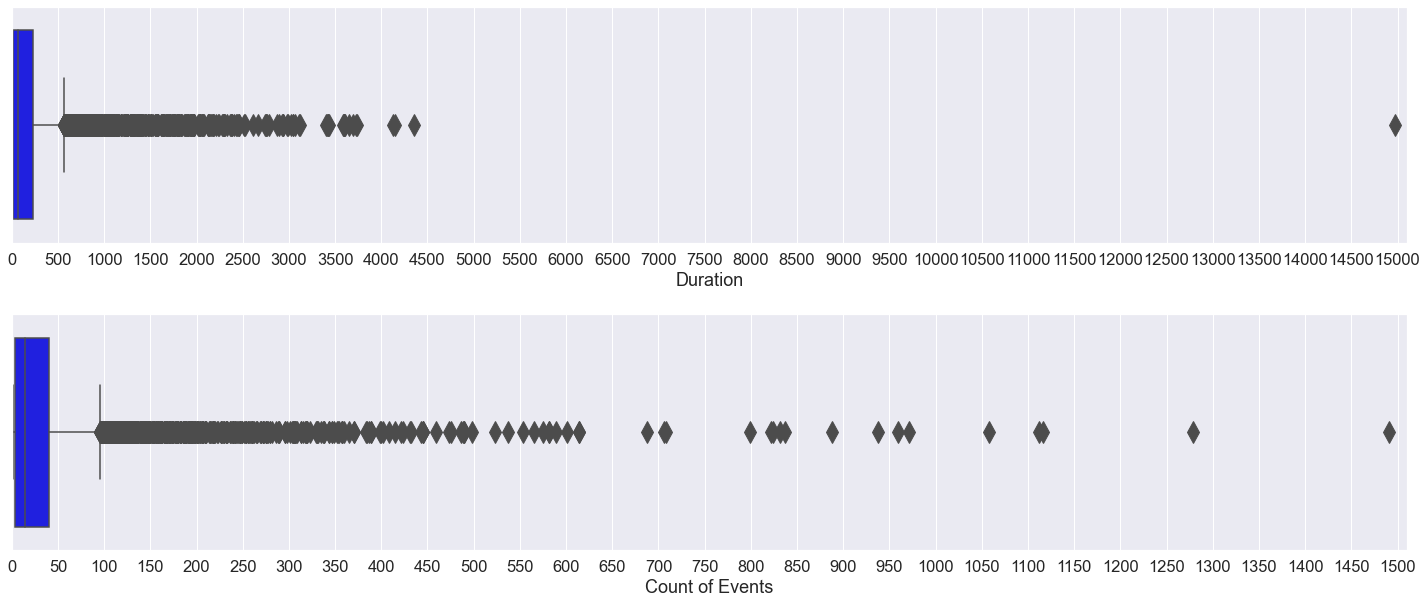

In [13]:
sns.set(rc={"figure.figsize": (25, 10)}, style="darkgrid", font_scale=1.5)
pyplot.subplot(2,1,1)
time_ax = sns.boxplot(x=sessions["duration"], color="blue", fliersize=15)
time_ax.set(xlabel="Duration", xticks=np.arange(0, 16000, 500), xlim=(0, 15100))
time_ax.margins(x=0)
pyplot.subplot(2,1,2)
time_ax = sns.boxplot(x=sessions["eventsCount"], color="blue", fliersize=15)
time_ax.set(xlabel="Count of Events", ylabel=None, xticks=np.arange(0, 1600, 50), xlim=(0, 1510))
time_ax.margins(x=0)
pyplot.subplots_adjust(hspace=0.3)
pyplot.show()

## Box Plots for Device Width and Height

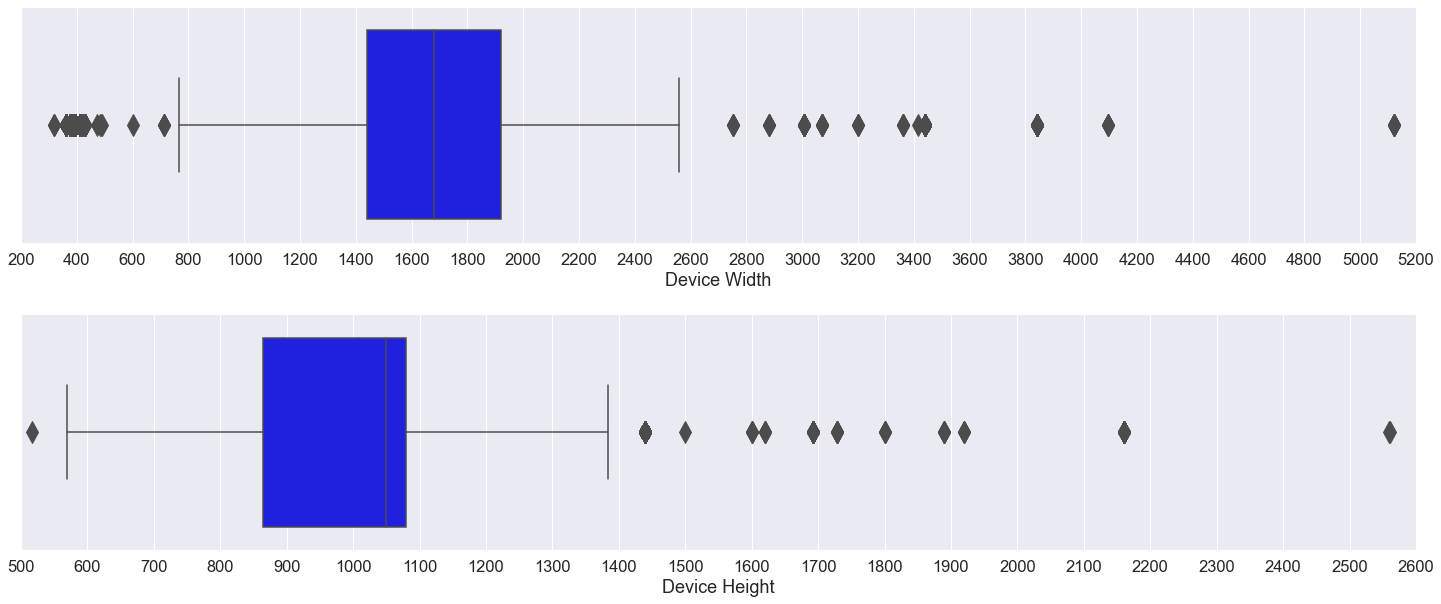

In [14]:
sns.set(rc={"figure.figsize": (25, 10)}, style="darkgrid", font_scale=1.5)
pyplot.subplot(2,1,1)
time_ax = sns.boxplot(x=sessions["deviceWidth"], color="blue", fliersize=15)
time_ax.set(xlabel="Device Width", xticks=np.arange(200, 5300, 200), xlim=(200, 5200))
time_ax.margins(x=0)
pyplot.subplot(2,1,2)
time_ax = sns.boxplot(x=sessions["deviceHeight"], color="blue", fliersize=15)
time_ax.set(xlabel="Device Height", ylabel=None, xticks=np.arange(500, 2650, 100), xlim=(500, 2600))
time_ax.margins(x=0)
pyplot.subplots_adjust(hspace=0.3)
pyplot.show()

## Pie Chart for Countries

Unique country codes: 99


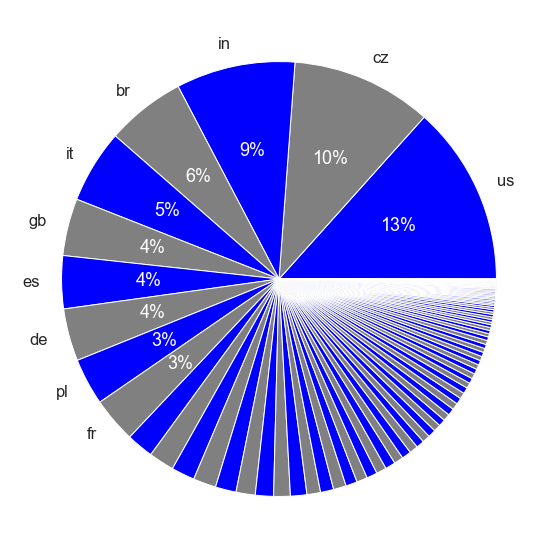

In [15]:
sns.set(rc = {'figure.figsize':(10,10)}, style="darkgrid", font_scale=1.5)
def autopct_more_than_3(pct):
    return ('%1.f%%' % pct) if pct >= 3 else ''
colors = sns.color_palette('Set1', len(sessions["countryCode"].cat.categories))
labels = sessions["countryCode"].value_counts().index[:10].to_list() + ["" for _ in sessions["countryCode"].value_counts().index[10:]]
_, _, autotexts = pyplot.pie(sessions["countryCode"].value_counts(), labels=labels, autopct=autopct_more_than_3, colors=["blue", "grey"])
[autotext.set_color('white') for autotext in autotexts]
print("Unique country codes:", len(sessions["countryCode"].unique()))

## Top Five Cities of the Sessions

In [16]:
sessions["countryCity"].value_counts()[:5]

Prague       282
Budapest      93
Bengaluru     89
Brno          84
São Paulo     77
Name: countryCity, dtype: int64

## Browser Distribution

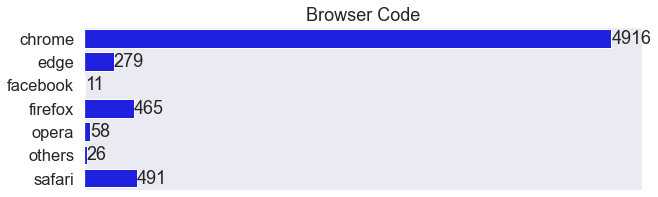

In [17]:
sns.set(rc = {'figure.figsize':(10,3)}, style="darkgrid", font_scale=1.5)
code_ax = sns.countplot(y=sessions["browserCode"], color="blue")
code_ax.set(xlabel=None, ylabel=None, xlim=(0, 5200), xticks=[], title="Browser Code")
code_ax.margins(x=0.05)
code_ax.bar_label(code_ax.containers[0])
pyplot.show()

## Device Distribution

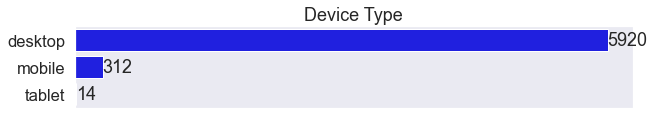

In [18]:
sns.set(rc = {'figure.figsize':(10,1.5)}, style="darkgrid", font_scale=1.5)
code_ax = sns.countplot(y=sessions["deviceType"], color="blue")
code_ax.set(xlabel=None, ylabel=None, xticks=[], xlim=(0, 6200), title="Device Type")
code_ax.margins(x=0.05)
code_ax.bar_label(code_ax.containers[0])
pyplot.show()

## Platform Distribution

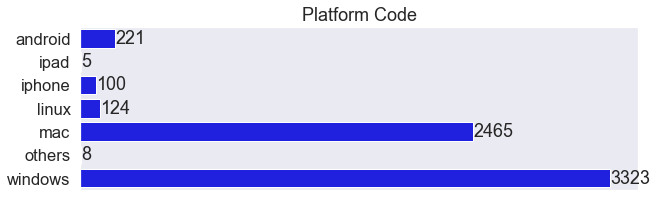

In [19]:
sns.set(rc = {'figure.figsize':(10,3)}, style="darkgrid", font_scale=1.5)
code_ax = sns.countplot(y=sessions["platformCode"], color="blue")
code_ax.set(xlabel=None, ylabel=None, xticks=[], xlim=(0, 3500), title="Platform Code")
code_ax.margins(x=0.05)
code_ax.bar_label(code_ax.containers[0])
pyplot.show()

## Device Width and Height Distribution

[]

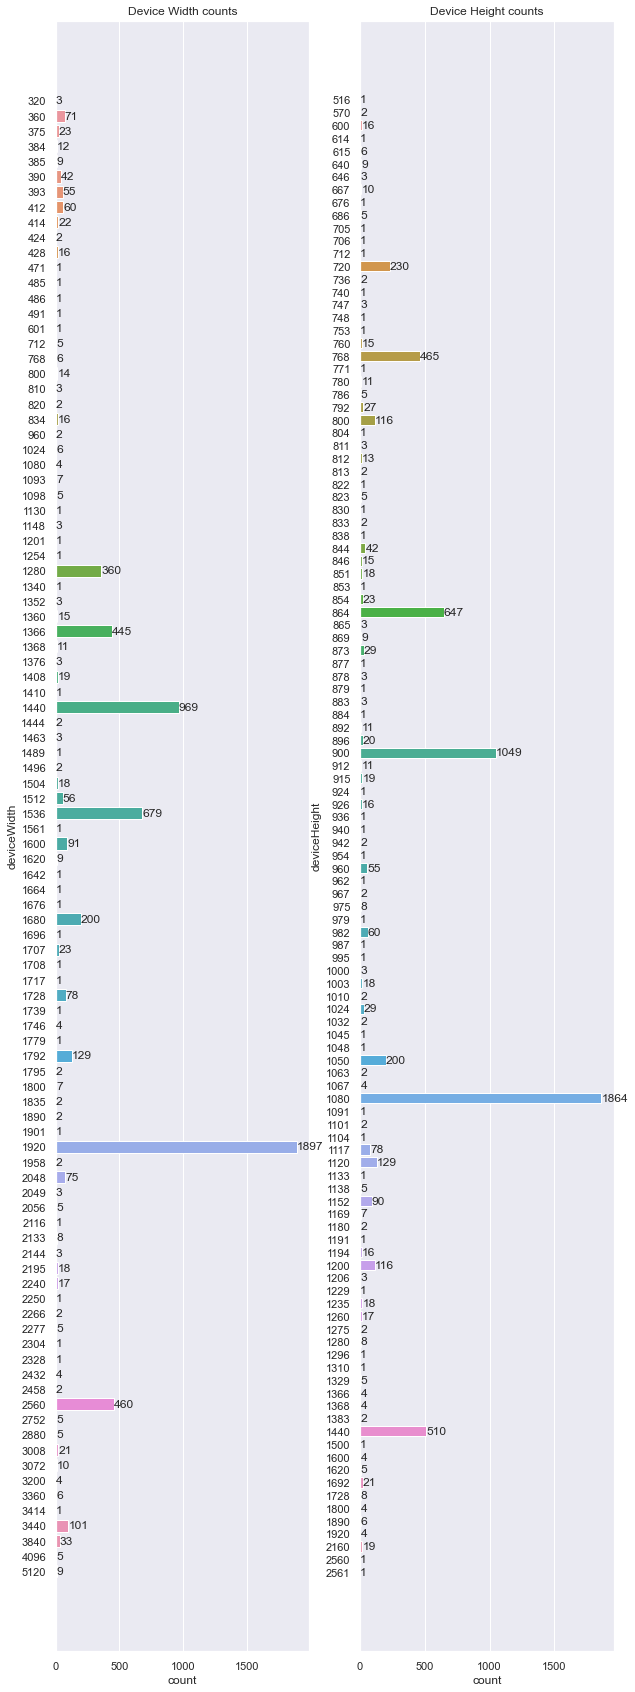

In [20]:
sns.set(rc = {'figure.figsize':(10,30)})
pyplot.subplot(1,2,1)
deviceWidth_ax = sns.countplot(y=sessions["deviceWidth"])
deviceWidth_ax.bar_label(deviceWidth_ax.containers[0])
deviceWidth_ax.set_title('Device Width counts')
deviceWidth_ax.plot()
pyplot.subplot(1,2,2)
deviceHeight_ax = sns.countplot(y=sessions["deviceHeight"])
deviceHeight_ax.bar_label(deviceHeight_ax.containers[0])
deviceHeight_ax.set_title('Device Height counts')
deviceHeight_ax.plot()

## Page Referrer, First, and Last Unique Value Counts

In [22]:
print("Page Referrer Unique Value Count:", len(sessions["pageReferer"].unique()))
print("Page First Unique Value Count:", len(sessions["pageFirst"].unique()))
print("Page Last Unique Value Count:", len(sessions["pageLast"].unique()))

Page Referrer Unique Value Count: 799
Page First Unique Value Count: 3738
Page Last Unique Value Count: 3852
